## Постановка задачи

**Предметная область:** работа магического портала, использующего энергию эфира, потоки стихий и параметры источников для поддержания стабильности перехода.

**Цель задачи:**  
на основе физических и магических параметров портала **оценить стабильность его работы**, представленную показателем  

"Гармония Бессмертия" — это целевая переменная (реальный коэффициент, 0–1).

Таким образом, задача относится к регрессии (целевой признак — числовой непрерывный).

---

### Признаковое пространство

| Признак | Смысл | Диапазон / Единицы | Тип данных |
|:--|:--|:--|:--|
| Вектор Мощи | Позиция механизма управления порталом | любое значение | float |
| Скорость перехода через портал | Скорость перемещения объектов | ≥ 0 | float |
| Приток Силы Потока | Магическая сила, питающая ядро | ≥ 0 | float |
| Ритм магического ядра | Частота вращения ядра | ≥ 0 | float |
| Поток Энергий | Преобразование внешней энергии | ≥ 0 | float |
| Сила Левого Потока | Мощность левого потока | ≥ 0 | float |
| Сила Правого Потока | Мощность правого потока | ≥ 0 | float |
| Пламя Стихий | Температура магического потока | °C, 0–1500 | float |
| Температура вдоха Истока | Температура входящего воздуха | °C, ~700–750 | int |
| Температура выдоха Истока | Температура выходящего воздуха | °C | float |
| Приток давления Выдоха Истока | Давление потока на выходе | любое | float |
| Давление входа Истока | Давление воздуха на входе | любое | float |
| Давление выдоха Истока | Давление воздуха на выходе | любое | float |
| Древний Ветер | Давление древней магической энергии | любое | float |
| Печать Чародея | Параметр впрыска магии | %, 0–100 | float |
| Эмульсия Истока | Количество магического топлива | ≥ 0 | float |
| Дыхание Истока | Коэффициент угасания ускорителя | 0–1 | float |
| Гармония Бессмертия | Коэффициент стабильности ядра (целевая) | 0–1 | float |
| Тип Вектора Мощи | Классификация позиции механизма | — | категориальный |
| Номер пометки | ID записи в журнале | любое | int |


---

### Ограничения и неиспользуемые признаки
- `Номер пометки` — уникальный идентификатор, не несёт информации.
- Формулы, напрямую использующие целевой признак (`Гармония Бессмертия`) исключаются из обучения, т.к. вызывают утечку данных.


In [27]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

import sys
print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)

Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Pandas: 2.1.4
NumPy: 1.26.4


### проверка кодировки

In [28]:
encodings = ["cp1251", "utf-8", "utf-8-sig", "latin-1"]

detected = None
for enc in encodings:
    try:
        _tmp = pd.read_csv('../data/portal_data.csv', encoding=enc, nrows=3)
        detected = enc
        break
    except Exception:
        pass

print(f"Кодировка: {detected}")
_tmp


Кодировка: cp1251


,Вектор Мощи|Скорость перехода через портал|Приток Силы Потока|Ритм магического ядра|Поток Энергий|Сила Левого Потока|Сила Правого Потока|Пламя Стихий|Температура вдоха Истока|Температура выдоха Истока|Приток давления Выдоха Истока|Давление вдоха Истока|Давление выдоха Истока|Древний Ветер|Печать Чародея|Эмульсия Истока|Дыхание Истока|Гармония Бессмертия|Тип Вектора Мощи|Номер пометки
0,1.138|1.54332|289.964|141.31815761667454|6677....
1,2.088|-|6960.18|144.1117665240017|6828.469|28....
2,3.144|4.6299600000000005|8379.229|145.22085345...


### разделение через |, вместо - NaN

In [29]:
data = pd.read_csv('../data/portal_data.csv', encoding=detected, sep="|")

data = data.replace("-", np.nan).replace("Не определено", np.nan)

print(data.shape)
data.head(10)


(11934, 20)


,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Тип Вектора Мощи,Номер пометки
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,NaN,1.096,NaN,5.947,NaN,7.137,0.082,0.95,0.975,Слабый,0
1,2.088,NaN,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975,Слабый,1
2,3.144,4.6299600000000005,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,NaN,1.389,NaN,7.574,NaN,13.086,0.259,0.95,0.975,Ниже среднего,2
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,NaN,1.658,NaN,9.007,NaN,18.109,0.358,0.95,0.975,Ниже среднего,3
4,5.140,7.7166,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,645.642,2.078,NaN,11.197,1.026,26.373,0.522,0.95,0.975,Выше среднего,4
5,6.175,9.25992,29792.731,241.630782,8828.360,246.278,246.278,800.434,736,676.397,2.501,NaN,13.356,1.03,35.760,0.708,0.95,0.975,Выше среднего,5
6,7.148,10.80324,38982.180,280.448510,9132.429,332.077,332.077,854.747,736,NaN,2.963,NaN,15.679,NaN,45.881,0.908,0.95,0.975,Сильный,6
7,8.206,12.34656,50996.808,323.328632,9318.562,437.989,437.989,952.122,736,NaN,3.576,NaN,18.632,NaN,62.440,1.236,0.95,0.975,Сильный,7
8,9.300,13.88988,72763.329,372.843693,9778.528,644.905,644.905,1115.797,736,NaN,4.498,1.394603,22.811,NaN,92.556,1.832,0.95,0.975,Сильный,8
9,1.138,1.54332,379.880,141.934538,6683.916,7.915,7.915,464.017,736,550.985,1.100,NaN,5.963,1.019,3.879,0.079,0.95,0.976,Слабый,9


###  анализ типов данных

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     11934 non-null  float64
 1   Скорость перехода через портал  10731 non-null  object 
 2   Приток Силы Потока              11934 non-null  float64
 3   Ритм магического ядра           11934 non-null  float64
 4   Поток Энергий                   11934 non-null  float64
 5   Сила Левого Потока              11934 non-null  float64
 6   Сила Правого Потока             11934 non-null  float64
 7   Пламя Стихий                    11934 non-null  float64
 8   Температура вдоха Истока        11934 non-null  int64  
 9   Температура выдоха Истока       2387 non-null   object 
 10  Приток давления Выдоха Истока   11934 non-null  float64
 11  Давление вдоха Истока           2439 non-null   object 
 12  Давление выдоха Истока          

### приведение к нужному типу

In [31]:
obj_to_float = [
    "Скорость перехода через портал",
    "Температура выдоха Истока",
    "Древний Ветер",
    "Давление вдоха Истока"
]

for c in obj_to_float:
    data[c] = pd.to_numeric(data.get(c), errors="coerce")

data["Номер пометки"] = pd.to_numeric(data["Номер пометки"], errors="coerce").astype("Int64")
data["Тип Вектора Мощи"] = data["Тип Вектора Мощи"].astype("category")

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Вектор Мощи                     11934 non-null  float64 
 1   Скорость перехода через портал  10731 non-null  float64 
 2   Приток Силы Потока              11934 non-null  float64 
 3   Ритм магического ядра           11934 non-null  float64 
 4   Поток Энергий                   11934 non-null  float64 
 5   Сила Левого Потока              11934 non-null  float64 
 6   Сила Правого Потока             11934 non-null  float64 
 7   Пламя Стихий                    11934 non-null  float64 
 8   Температура вдоха Истока        11934 non-null  int64   
 9   Температура выдоха Истока       2387 non-null   float64 
 10  Приток давления Выдоха Истока   11934 non-null  float64 
 11  Давление вдоха Истока           2439 non-null   float64 
 12  Давление выдоха Ис

In [32]:
data

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Тип Вектора Мощи,Номер пометки
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,NaN,1.096,NaN,5.947,NaN,7.137,0.082,0.95,0.975,Слабый,0
1,2.088,NaN,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975,Слабый,1
2,3.144,4.62996,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,NaN,1.389,NaN,7.574,NaN,13.086,0.259,0.95,0.975,Ниже среднего,2
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,NaN,1.658,NaN,9.007,NaN,18.109,0.358,0.95,0.975,Ниже среднего,3
4,5.140,7.71660,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,645.642,2.078,NaN,11.197,1.026,26.373,0.522,0.95,0.975,Выше среднего,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11929,5.140,7.71660,21624.934,201.516623,8470.013,175.239,175.239,681.658,736,628.950,2.087,NaN,10.990,1.027,23.803,0.471,1.00,1.000,Выше среднего,11929
11930,6.175,9.25992,29763.213,241.561772,8800.352,245.954,245.954,747.405,736,NaN,2.512,NaN,13.109,NaN,32.671,0.647,1.00,1.000,Выше среднего,11930
11931,7.148,10.80324,39003.867,280.444950,9120.889,332.389,332.389,796.457,736,680.393,2.982,NaN,15.420,1.036,42.104,0.834,1.00,1.000,Сильный,11931
11932,8.206,12.34656,50992.579,323.315332,9300.274,438.024,438.024,892.945,736,NaN,3.594,NaN,18.293,NaN,58.064,1.149,1.00,1.000,Сильный,11932


### первичное отбрасывание признаков

In [33]:
drop_cols = ["Номер пометки"]
data = data.drop(columns=drop_cols)

print("После удаления:", data.shape)
data.head()


После удаления: (11934, 19)


,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Тип Вектора Мощи
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,NaN,1.096,NaN,5.947,NaN,7.137,0.082,0.95,0.975,Слабый
1,2.088,NaN,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975,Слабый
2,3.144,4.62996,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,NaN,1.389,NaN,7.574,NaN,13.086,0.259,0.95,0.975,Ниже среднего
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,NaN,1.658,NaN,9.007,NaN,18.109,0.358,0.95,0.975,Ниже среднего
4,5.140,7.71660,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,645.642,2.078,NaN,11.197,1.026,26.373,0.522,0.95,0.975,Выше среднего


### 4)разделение на трейн и тест

Температура выдоха Истока         9547
Древний Ветер                     9547
Давление вдоха Истока             9495
Скорость перехода через портал    1203
Приток давления Выдоха Истока        0
Гармония Бессмертия                  0
Дыхание Истока                       0
Эмульсия Истока                      0
Печать Чародея                       0
Давление выдоха Истока               0
dtype: int64


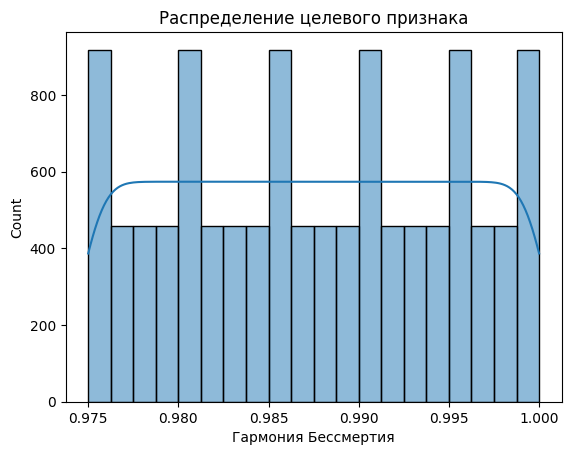

Train shape: (9547, 18), Test shape: (2387, 18)


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

print(data.isna().sum().sort_values(ascending=False).head(10))
sns.histplot(data["Гармония Бессмертия"], bins=20, kde=True)
plt.title("Распределение целевого признака")
plt.show()

X = data.drop(columns=["Гармония Бессмертия"])
y = data["Гармония Бессмертия"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# 3

### 1) кодирование категориальных признаков (модифицированный лейбл)

In [35]:
#посмотррим категориальные признаки
cat_columns = X_train.select_dtypes(include=['object', 'category'])
print(cat_columns)

#посмотрим уникальные значения(понадобится для кодирования)
print("Уникальные значения в X_train['Тип Вектора Мощи']:")
print(X_train["Тип Вектора Мощи"].unique())

      Тип Вектора Мощи
3685     Выше среднего
5886            Слабый
6108           Сильный
7713            Слабый
3499           Сильный
...                ...
11284          Сильный
5191           Сильный
5390           Сильный
860      Выше среднего
7270           Сильный

[9547 rows x 1 columns]
Уникальные значения в X_train['Тип Вектора Мощи']:
['Выше среднего', 'Слабый', 'Сильный', 'Ниже среднего']
Categories (4, object): ['Выше среднего', 'Ниже среднего', 'Сильный', 'Слабый']


##### т.к. лейбл кодироет по порядку а не по смыслу, зададим порядок сами

In [36]:
# Задаём порядок вручную (по смыслу признака)
label_mapping = {
    "Слабый": 0,
    "Ниже среднего": 1,
    "Выше среднего": 2,
    "Сильный": 3
}

# Применяем к обучающей выборке
X_train["Тип Вектора Мощи"] = X_train["Тип Вектора Мощи"].map(label_mapping)


### применим к тестовой выборке

In [37]:
X_test["Тип Вектора Мощи"] = X_test["Тип Вектора Мощи"].map(label_mapping)
X_train.head(10)

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Тип Вектора Мощи
3685,5.140,NaN,21634.909,201.516309,8497.497,175.278,175.278,704.972,736,NaN,2.078,NaN,11.004,NaN,24.951,0.494,0.965,2
5886,1.138,1.54332,2706.698,138.966361,6622.351,6.270,6.270,545.800,736,NaN,1.184,NaN,6.450,NaN,26.222,0.194,0.975,0
6108,7.148,10.80324,38998.248,280.444531,9120.644,332.275,332.275,835.034,736,NaN,2.980,NaN,15.730,NaN,44.789,0.887,0.976,3
7713,1.138,1.54332,6763.006,144.782287,6697.636,9.375,9.375,620.925,736,NaN,1.322,NaN,7.078,NaN,0.000,0.278,0.982,0
3499,8.206,12.34656,50994.067,323.324443,9319.460,438.106,438.106,917.854,736,NaN,3.566,NaN,18.180,NaN,59.577,1.179,0.964,3
4963,5.140,7.71660,21630.599,201.513796,8479.072,175.272,175.272,715.290,736,NaN,2.084,1.394603,11.171,NaN,25.585,0.506,0.971,2
4091,6.175,9.25992,29791.466,241.633505,8822.265,246.201,246.201,778.048,736,NaN,2.504,NaN,13.224,NaN,34.448,0.682,0.967,2
6489,1.138,1.54332,3346.542,148.184423,6712.135,11.322,11.322,529.705,736,NaN,1.221,NaN,6.532,NaN,0.000,0.162,0.977,0
1379,3.144,4.62996,8380.957,145.222005,7159.710,60.377,60.377,585.006,736,NaN,1.387,NaN,7.410,NaN,12.226,0.242,0.955,1
9440,9.300,13.88988,72763.303,372.841912,9738.873,644.962,644.962,1063.563,736,NaN,4.538,NaN,22.854,NaN,88.590,1.754,0.990,3


### заполнение пропусков

In [38]:
# Сколько NaN в каждом столбце (только в train!)
print("Пропуски в X_train:")
print(X_train.isna().sum())

Пропуски в X_train:
Вектор Мощи                          0
Скорость перехода через портал     961
Приток Силы Потока                   0
Ритм магического ядра                0
Поток Энергий                        0
Сила Левого Потока                   0
Сила Правого Потока                  0
Пламя Стихий                         0
Температура вдоха Истока             0
Температура выдоха Истока         7160
Приток давления Выдоха Истока        0
Давление вдоха Истока             7603
Давление выдоха Истока               0
Древний Ветер                     7160
Печать Чародея                       0
Эмульсия Истока                      0
Дыхание Истока                       0
Тип Вектора Мощи                     0
dtype: int64


In [39]:
# Получаем список всех числовых признаков
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
print("Числовые столбцы:", num_cols)

Числовые столбцы: ['Вектор Мощи', 'Скорость перехода через портал', 'Приток Силы Потока', 'Ритм магического ядра', 'Поток Энергий', 'Сила Левого Потока', 'Сила Правого Потока', 'Пламя Стихий', 'Температура вдоха Истока', 'Температура выдоха Истока', 'Приток давления Выдоха Истока', 'Давление вдоха Истока', 'Давление выдоха Истока', 'Древний Ветер', 'Печать Чародея', 'Эмульсия Истока', 'Дыхание Истока']


##### используем статистический подход

In [40]:
#функция кл-дивергенции
from scipy.stats import entropy

def kl_div(p, q):
    p = np.array(p) + 1e-10  # избегаем log(0)
    q = np.array(q) + 1e-10
    p = p / p.sum()
    q = q / q.sum()
    return entropy(p, q)


Анализ признака: Скорость перехода через портал
  mean: KL = 0.106094
  median: KL = 0.028762


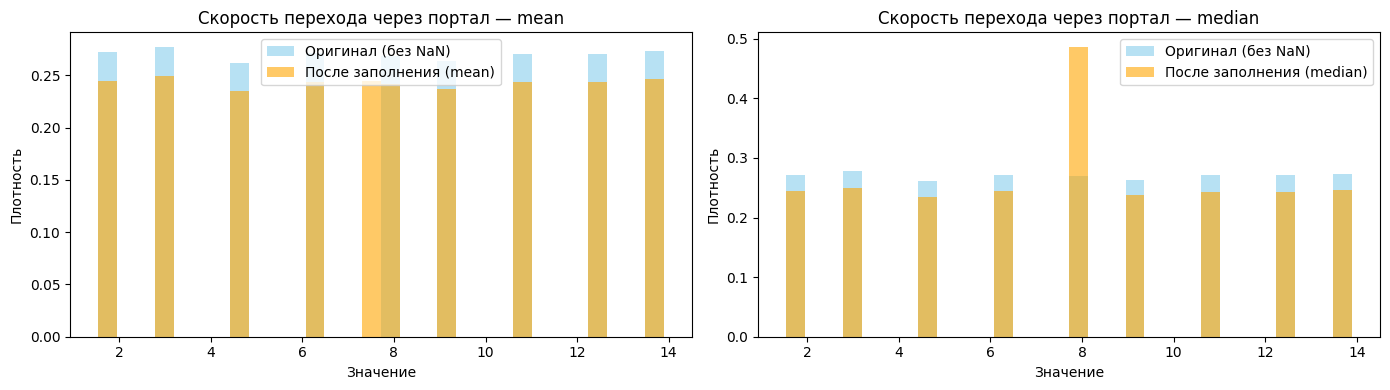

  → Выбрано: median = 7.7166 (KL = 0.028762)


Анализ признака: Температура выдоха Истока
  mean: KL = 1.288793
  median: KL = 1.100868


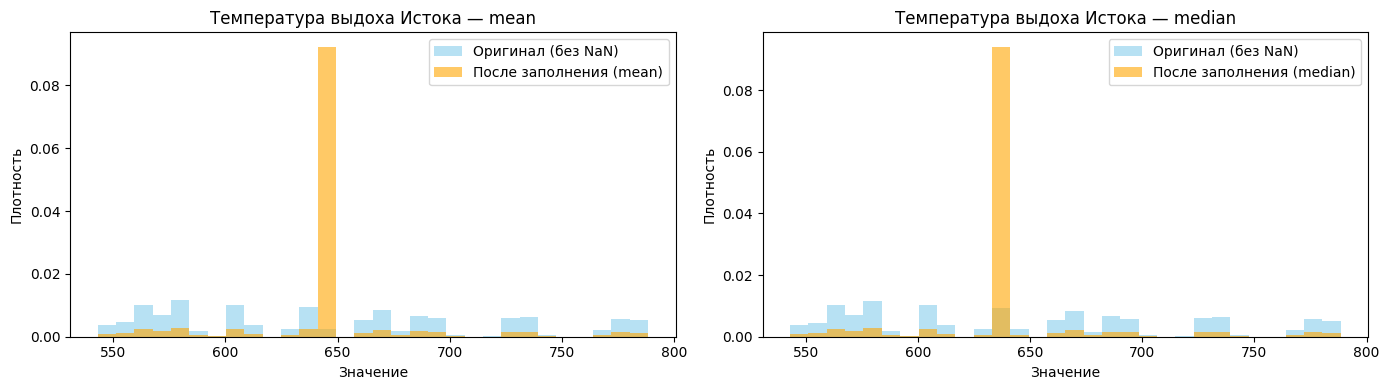

  → Выбрано: median = 636.9630 (KL = 1.100868)


Анализ признака: Давление вдоха Истока
  mean: KL = 0.000000
  median: KL = 0.000000


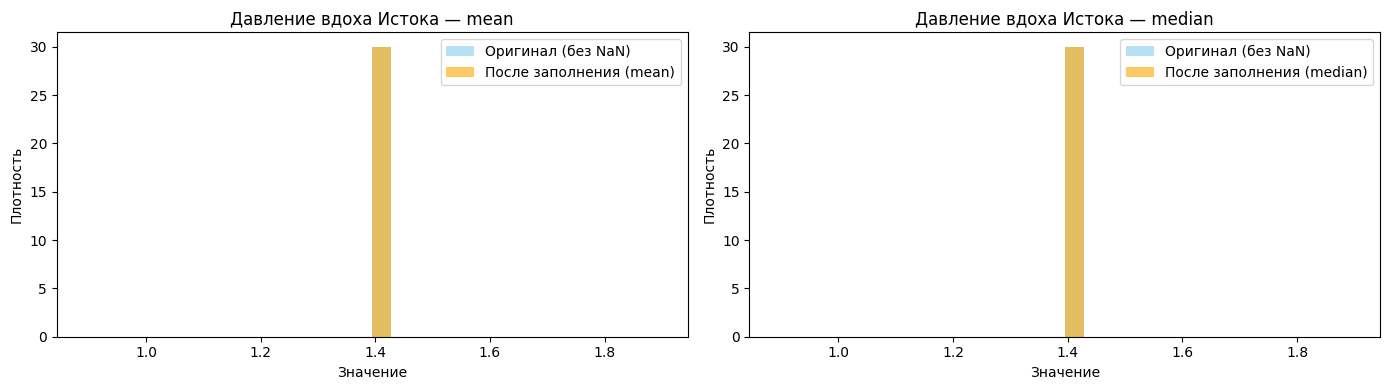

  → Выбрано: mean = 1.3946 (KL = 0.000000)


Анализ признака: Древний Ветер
  mean: KL = 1.386190
  median: KL = 1.074248


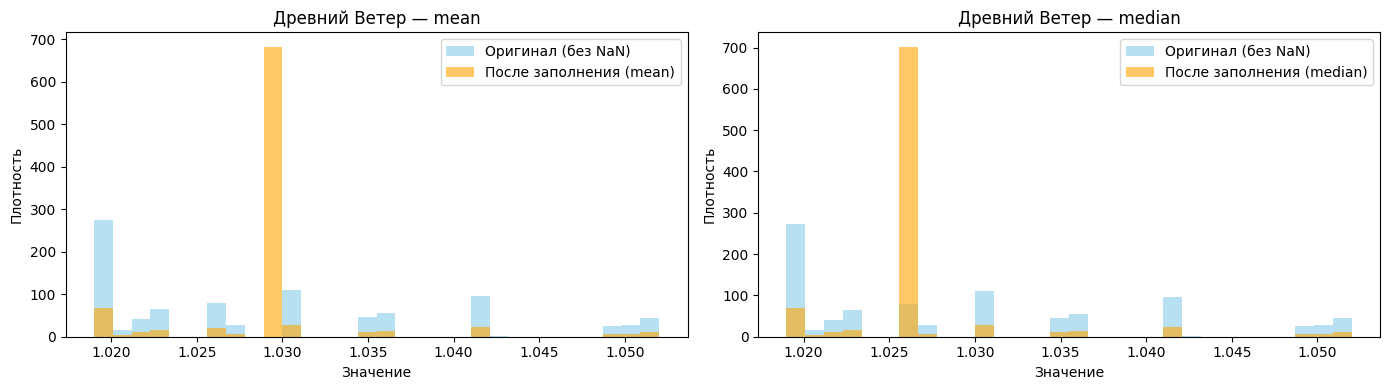

  → Выбрано: median = 1.0260 (KL = 1.074248)



In [41]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy


best_fill_values = {}

for col in num_cols:
    if X_train[col].isna().sum() == 0:
        continue

    print(f"\nАнализ признака: {col}")
    orig = X_train[col].dropna()

    # Кандидаты для заполнения
    candidates = {
        'mean': orig.mean(),
        'median': orig.median()
    }

    best_kl = float('inf')
    best_val = candidates['median']
    best_name = 'median'

    # Строим гистограмму оригинала (без NaN)
    plt.figure(figsize=(14, 4))

    for i, (name, val) in enumerate(candidates.items(), 1):
        # Заполняем пропуски
        filled = X_train[col].fillna(val)

        # Строим гистограммы
        plt.subplot(1, 2, i)
        plt.hist(orig, bins=30, alpha=0.6, label='Оригинал (без NaN)', density=True, color='skyblue')
        plt.hist(filled, bins=30, alpha=0.6, label=f'После заполнения ({name})', density=True, color='orange')
        plt.title(f'{col} — {name}')
        plt.xlabel('Значение')
        plt.ylabel('Плотность')
        plt.legend()

        # Вычисляем KL-дивергенцию
        hist_orig, bins = np.histogram(orig, bins=30, density=True)
        hist_filled, _ = np.histogram(filled, bins=bins, density=True)
        kl = kl_div(hist_orig, hist_filled)
        print(f"  {name}: KL = {kl:.6f}")

        if kl < best_kl:
            best_kl = kl
            best_val = val
            best_name = name

    plt.tight_layout()
    plt.show()  

    best_fill_values[col] = best_val
    print(f"  → Выбрано: {best_name} = {best_val:.4f} (KL = {best_kl:.6f})\n")

### используем машинный подход( именно этот,т.к. пропуском много и он не сможет найти какието похожие значения, а вычислит их как функцию от других переменных)

In [42]:

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Создаём и обучаем импьютер на X_train (уже без категориальных признаков!)
iter_imp = IterativeImputer(random_state=42, max_iter=10)



### 4)применяем на тест и на трейн

In [43]:
#применяем статистические к трейн и тест
X_train_stat = X_train.copy()
X_test_stat = X_test.copy()

for col, fill_val in best_fill_values.items():
    X_train_stat[col] = X_train_stat[col].fillna(fill_val)
    X_test_stat[col] = X_test_stat[col].fillna(fill_val)

print(" Статистическое заполнение завершено.")

 Статистическое заполнение завершено.


In [44]:
#применяем машинное на трейна и на тесте
X_train_iter = pd.DataFrame(
    iter_imp.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_iter = pd.DataFrame(
    iter_imp.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)


print(" Машинное заполнение (IterativeImputer) завершено.")

 Машинное заполнение (IterativeImputer) завершено.


In [45]:
print("Проверка пропусков:")
print("Статистический — train:", X_train_stat.isna().sum().sum())
print("Статистический — test: ", X_test_stat.isna().sum().sum())
print("Машинный — train:      ", X_train_iter.isna().sum().sum())
print("Машинный — test:       ", X_test_iter.isna().sum().sum())

Проверка пропусков:
Статистический — train: 0
Статистический — test:  0
Машинный — train:       0
Машинный — test:        0
